# Part III. Compare intensity matrices

- Now that we have color matrices for every image, we can compare reference vs experiment picture intensities
- Identify those colonies with highest intensity differences and match them with the corresponding genes
- We only consider the colonies where at least 3 out of 4 repetions have high intensity differences

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from glob import glob
import os

import pandas as pd
from scipy import ndimage
from importlib import reload
from skimage import exposure

# Step 1. Load the appropriate data

- Just like in prior notebooks
- Also load the gene data `data` csv
- Define which gene index `lgdix` to compare to which gene control index `mgidx`

In [3]:
fs = 15

data = pd.read_csv('..' + os.sep + 'library_eY2H.csv')

src = '..' + os.sep + 'proc' + os.sep
lsrc = src + 'leyre' + os.sep
msrc = src + 'mather' + os.sep
dst = '..' + os.sep + 'proc' + os.sep
diagdst = '..' + os.sep + 'diagnostic' + os.sep

lgenes = os.listdir(lsrc)
mgenes = os.listdir(msrc)
print('Reference:\t', mgenes, '\nGenes to test:\t', lgenes, sep='')

Reference:	['p53']
Genes to test:	['LBD37']


In [4]:
lgidx, mgidx = 0,0
print('Comparing gene', lgenes[lgidx], 'with reference', mgenes[mgidx] )
gdst = dst + lsrc.split(os.sep)[-2] + os.sep + lgenes[lgidx] + os.sep
mdst = dst + msrc.split(os.sep)[-2] + os.sep + mgenes[mgidx] + os.sep
print('Will save all results in ',gdst)
ddst = diagdst + lsrc.split(os.sep)[-2] + os.sep + lgenes[lgidx] + os.sep

Comparing gene LBD37 with reference p53
Will save all results in  ../proc/leyre/LBD37/


# Step 2. Standardize intensities

- It can well be the case that the red intensity values in control are different from the red intensities in our pictures
- We thus match intensity histograms so that their cumulative distributions coincide
- That way differences are more meaningful
- `platenum`: Specify which plate number to compare

In [5]:
platenum = 6

ref_file = glob(msrc + mgenes[mgidx] + os.sep + '*_{:02d}_colormatrix.csv'.format(platenum) )[0]
plate_file = glob(lsrc + lgenes[lgidx] + os.sep + '*_{:02d}_colormatrix.csv'.format(platenum) )[0]
bname = '_'.join((os.path.split(os.path.splitext(plate_file)[0])[1]).split('_')[:-1])

print(ref_file, plate_file, bname, sep='\n')

../proc/mather/p53/p53_plate_06_colormatrix.csv
../proc/leyre/LBD37/20231130_plate_06_colormatrix.csv
20231130_plate_06


In [6]:
reference = np.loadtxt(ref_file, delimiter=',')
plate = np.loadtxt(plate_file, delimiter=',')
nrows, ncols = plate.shape
nonzeros = plate != 0

reference[~nonzeros] = 0
matched = exposure.match_histograms(plate, reference, channel_axis=None)

diff = reference - matched
diff[~nonzeros] = 0
vlim = np.max( np.abs( [ np.min(diff), np.max(diff) ] ) )

rhist, bins = np.histogram(reference, bins=range(1,257))
phist, _ = np.histogram(plate, bins=bins)
mhist, _ = np.histogram(matched, bins=bins)

imgsize = np.sum(nonzeros)
rcumsum = np.cumsum(rhist)/reference.size
pcumsum = np.cumsum(phist)/imgsize
mcumsum = np.cumsum(mhist)/imgsize

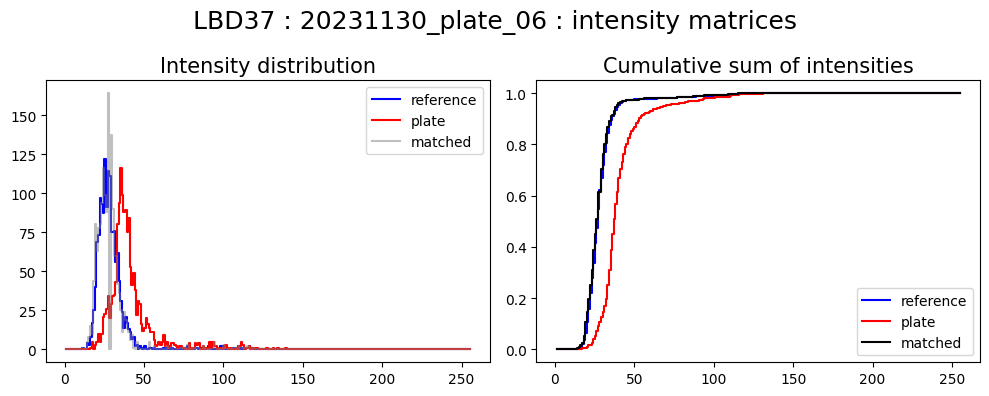

In [7]:
fig, ax = plt.subplots(1,2, figsize=(10,4), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].plot(bins[:-1], rhist, c='blue', ds='steps', label='reference')
ax[i].plot(bins[:-1], phist, c='red', ds='steps', label='plate')
ax[i].plot(bins[:-1], mhist, c='gray', ds='steps', alpha=0.5, label='matched')
ax[i].set_title('Intensity distribution', fontsize=fs)

i+=1
ax[i].plot(bins[:-1], rcumsum, c='blue', ds='steps', label='reference')
ax[i].plot(bins[:-1], pcumsum, c='red', ds='steps', label='plate')
ax[i].plot(bins[:-1], mcumsum, c='k', ds='steps', label='matched')
ax[i].set_title('Cumulative sum of intensities', fontsize=fs)

for i in range(len(ax)):
    ax[i].legend();

fig.suptitle(lgenes[lgidx] + ' : ' + bname + ' : intensity matrices', fontsize=fs+3)
fig.tight_layout()

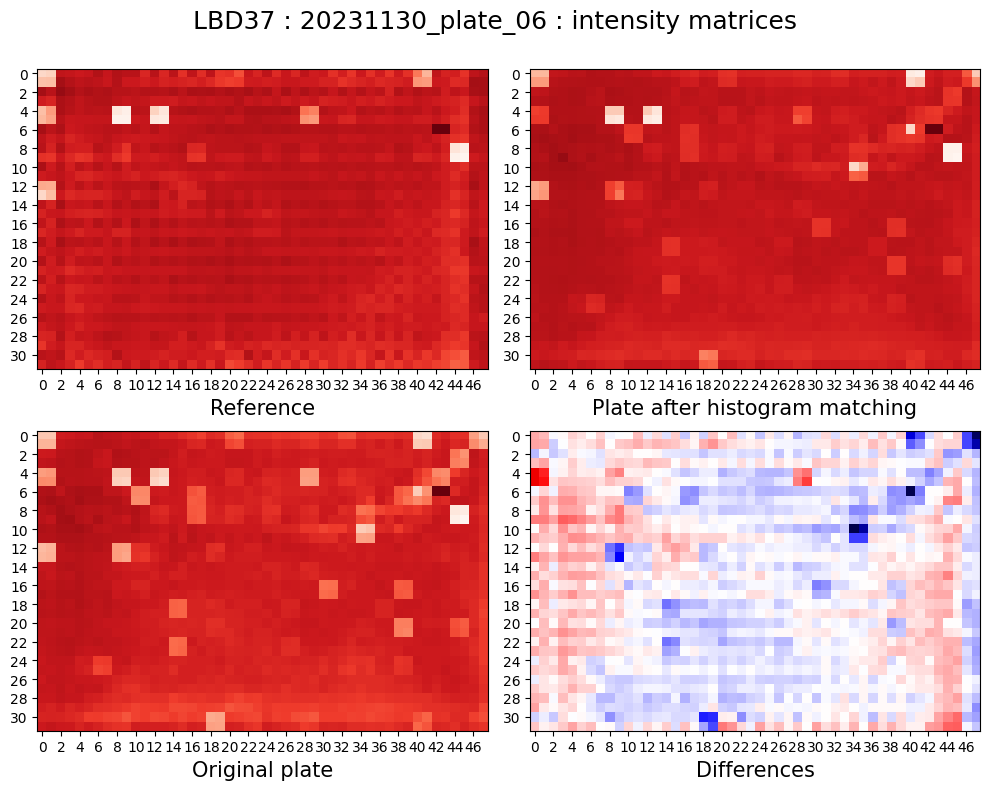

In [8]:
fig, ax = plt.subplots(2,2, figsize=(10,8), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[0].imshow(reference, cmap='Reds_r')
ax[0].set_xlabel('Reference', fontsize=fs)
ax[1].imshow(matched, cmap='Reds_r')
ax[1].set_xlabel('Plate after histogram matching', fontsize=fs)
ax[2].imshow(plate, cmap='Reds_r')
ax[2].set_xlabel('Original plate', fontsize=fs)
ax[3].imshow(diff, cmap='seismic', vmin=-vlim, vmax=vlim)
ax[3].set_xlabel('Differences', fontsize=fs)

for i in range(len(ax)):
    ax[i].set_xticks(range(0,ncols,2), range(0,ncols,2))
    ax[i].set_yticks(range(0,nrows,2), range(0,nrows,2));
    ax[i].set_aspect('equal')

fig.suptitle(lgenes[lgidx] + ' : ' + bname + ' : intensity matrices', fontsize=fs+3)
fig.tight_layout()

# Step 3. Find outliers

### The mean differences are NOT normal

- Taking the average of the four intensity differences per gene, I noticed that these `means` are **not** normally distributed
- Thus a t-Test is not advised
- Better tests like Wilcoxon have less a priori restrictions
- But just 4 samples per gene is too small to do any meaningful statistics

## What then if not t-Tests?

- So far I've noticed that the differences follow a Laplace distribution
- This is purely a visual assessment and have no real idea on why this could be the case (stats is not my strength)
- The Laplace distribution by definition is a symmetric exponential distribution.
- But I don't see right away anything here that can be related to the exponential distribution.
- My best guess has to do with the fact that if $X_1, X_2, X_3, X_4$ are random variables that follow a normal distributions [then](https://en.wikipedia.org/wiki/Laplace_distribution#Related_distributions):
$$X_1X_2 - X_3X_4 \sim (X_1^2-X_2^2+X_3^2-X_4^2)/2 \sim Laplace$$
- And that the [product of two normal random variables](https://math.stackexchange.com/questions/101062/is-the-product-of-two-gaussian-random-variables-also-a-gaussian) tends to be the linear combination of two $\chi^2$-distributions.

In [9]:
means = np.zeros((nrows//2, ncols//2))
for i in range(0,nrows,2):
    for j in range(0, ncols, 2):
        means[i//2,j//2] = np.mean(diff[i:i+2, j:j+2])

dhist, dbins = np.histogram(diff[nonzeros], bins=np.linspace(-vlim-1, vlim+1, 101), density=True)
dcumsum = np.cumsum(dhist)
dcdf = (dcumsum - dcumsum[0])/(dcumsum[-1] - dcumsum[0])
xvals = dbins[:-1].copy()

mhist, _ = np.histogram(means, bins=dbins, density=True)
mcumsum = np.cumsum(mhist)
mcdf = (mcumsum - mcumsum[0])/(mcumsum[-1] - mcumsum[0])

mu, sigma = np.mean(diff), np.std(diff)
normal = 1/(np.std(diff) * np.sqrt(2 * np.pi))*np.exp( - (xvals - np.mean(diff))**2 / (2 * np.std(diff)**2))
ncumsum = np.cumsum(normal)
ncdf = (ncumsum - ncumsum[0])/(ncumsum[-1] - ncumsum[0])

b = np.std(diff)/np.sqrt(2)
laplace = np.exp(-abs(xvals)/b)/(2.*b)

lcdf = np.zeros(len(xvals))
lcdf[xvals < 0] = 0.5*np.exp((xvals[xvals < 0])/b)
lcdf[xvals >= 0] = 1-0.5*np.exp(-(xvals[xvals >= 0])/b)
print(' -- Empirical mean:\t',mu, '\n -- Empirical std:\t', sigma, '\n -- Max difference:\t', vlim, sep='')

 -- Empirical mean:	0.013884583948531056
 -- Empirical std:	9.197909492609586
 -- Max difference:	79.0


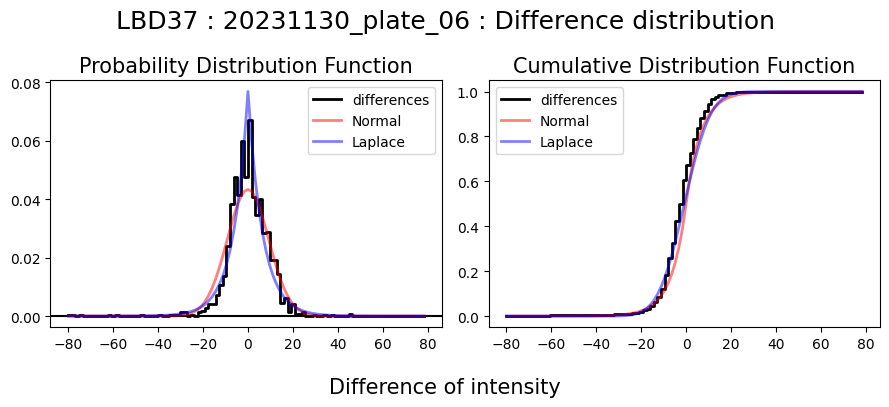

In [14]:
fig, ax = plt.subplots(1,2, figsize=(9,4), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].axhline(0, c='k')
ax[i].plot(xvals, dhist, c='k', lw=2, ds='steps-post', label='differences', zorder=1)
#ax[i].plot(xvals, mhist, c='green', lw=2, ds='steps', label='means', alpha=0.5, zorder = 2)
ax[i].plot(xvals, normal, c='red', lw=2, label='Normal', alpha=0.5 , zorder = 3)
ax[i].plot(xvals, laplace, c='blue', lw=2, label='Laplace', alpha=0.5, zorder = 4 )
ax[i].set_title('Probability Distribution Function', fontsize=fs)

i+=1
ax[i].plot(xvals, dcdf, c='k', label='differences', ds='steps', lw=2, alpha=1, zorder=1)
#ax[i].plot(xvals, dcdf, c='green', label='means', ds='steps', lw=2, alpha=1, zorder=2)
ax[i].plot(xvals, lcdf, c='r', label='Normal', lw=2, alpha=0.5, zorder=3)
ax[i].plot(xvals, ncdf, c='b', label='Laplace', lw=2, alpha=0.5, zorder=4)
ax[i].set_title('Cumulative Distribution Function', fontsize=fs)

for i in range(len(ax)):
    ax[i].legend();
fig.supxlabel('Difference of intensity', fontsize=fs)
fig.suptitle(lgenes[lgidx] + ' : ' + bname + ' : Difference distribution', fontsize=fs+3)
fig.tight_layout()

filename = ddst + 'difference_distribution_' + bname + '.jpg'
plt.savefig(filename, format='jpg', dpi=100, bbox_inches='tight', pil_kwargs={'optimize':True})

# Assuming that intensity differences follow a Laplace distribution

- Fix a small $\alpha$ value (like `alpha = 0.01`)
- I will ignore `1 - 2*alpha` (0.98 in this case) of Laplace central mass
- I will only consider difference values that have only `alpha` probability to happen (2% chance in this case)
- That is, I will only consider values that happen at the end tails of the Laplace distribution

## Alternative to find outliers

- The differences that are 3 standard deviations away from the mean (which should be 0)
- Differences larger than $Q_3 + 1.5\times IQR$ or smaller than $Q_1 - 1.5\times IQR$, like when making a [box plot](https://en.wikipedia.org/wiki/Box_plot). IQR is the inter-quartile range.

Setting alpha = 	0.01
Only considering differences larger than	25.44342275756072
Or smaller than	-25.44342275756072


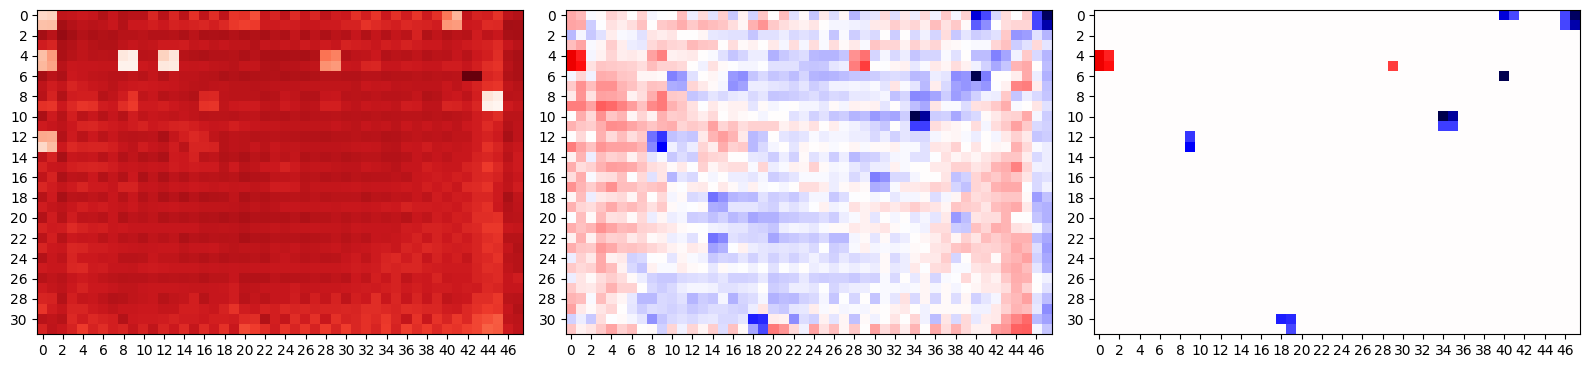

In [32]:
# FIND OUTLIERS BY SOME CRITERIA

# 1. Assume differences follow a Laplace distrubution. Outliers will be those outside the 1-alpha interval

alpha = 0.01
threshold = np.abs(b * np.log(2*alpha))
print('Setting alpha = \t', alpha, '\nOnly considering differences larger than\t', threshold, '\nOr smaller than\t', -threshold, sep='')
tmask = np.abs(diff) > threshold

# 2. Outliers are those 3 stds away from the mean
#threshold = 3*np.std(diff)
#tmask = np.abs(diff) > threshold

# 3. Outliers will be those outside far away from the IQR, like when making boxplots
#q1,q3 = np.quantile(diff, [0.2,0.8]); iqr = q1 - q3
#tmask = (diff < q1 - 1.5*iqr) | (diff > q3 + 1.5*iqr)

fig, ax = plt.subplots(1,3, figsize=(16,5), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[0].imshow(reference, cmap='Reds_r')
ax[1].imshow(diff, cmap='seismic', vmin=-vlim, vmax=vlim)
ax[2].imshow(diff*tmask, cmap='seismic', vmin=-vlim, vmax=vlim)

for i in range(len(ax)):
    ax[i].set_xticks(range(0,ncols,2), range(0,ncols,2))
    ax[i].set_yticks(range(0,nrows,2), range(0,nrows,2));
fig.tight_layout()

# Step 4. Match differences to gene database

- Only consider the colonies where at least 3 out of 4 have significant intensity differences.
- Based on row and column information, we match our results with the gene database
- The genes are sumarized in a dataframe `signif`
- We also keep record of the intensity difference and a quick reminder of the color of the colonies

In [33]:
signifscores = np.zeros((nrows//2, ncols//2), dtype=np.uint8)

for i in range(0,nrows,2):
    for j in range(0, ncols, 2):
        signifscores[i//2, j//2] = np.sum(tmask[i:i+2, j:j+2])

signifcoords = np.asarray(np.nonzero(signifscores > 2))
signifcoords

array([[ 0,  2,  5, 15],
       [23,  0, 17,  9]])

In [34]:
signifidx = np.zeros(len(signifcoords[0]), dtype=int) - 1
diffvals = np.zeros(len(signifidx))
controlcol = np.repeat(['whiteish'], len(signifidx)).astype('<U10')
platecol = np.repeat(['redish'], len(signifidx)).astype('<U10')

for i in range(len(signifidx)):
    coordinate = 'p{:02d}-r{:02d}-c{:02d}'.format(platenum, signifcoords[0,i]+1, signifcoords[1,i]+1)
    ref = data[data['Coordinate'] == coordinate]
    if len(ref) > 0:
        signifidx[i] = ref.index[0]
        diffvals[i] = diff[2*signifcoords[0,i], 2*signifcoords[1,i]]
        if diffvals[i] < 0:
            controlcol[i] = 'redish'
            platecol[i] = 'whiteish'

signifmask = signifidx > -1

signif = data.loc[signifidx[signifmask]]
signif['IntensityDiff'] = diffvals[signifmask]
signif['ControlColor'] = controlcol[signifmask]
signif['PlateColor'] = platecol[signifmask]
signif

,Identifier,Coordinate,Family,Common_Name,SubCellular,SubOrganellar,IntensityDiff,ControlColor,PlateColor
7703,EV,p06-r01-c24,EV,EV,-,-,-29.0,redish,whiteish
7776,EV,p06-r03-c01,EV,EV,-,-,45.0,whiteish,redish
7937,AT2G41900,p06-r06-c18,C3H,OXS2,Nucleus,Chromosome,-79.0,redish,whiteish
8409,EV,p06-r16-c10,EV,EV,-,-,-35.0,redish,whiteish


# Step 5. Save the results

In [ ]:
filename = gdst + bname + '_significant_differences.csv'
print(filename)
signif.to_csv(filename, index=True, index_label='OriginalIndex')

# Just for mental sanity

- Let's plot the colonies that were reported with high intensity differences to visually check that they make sense and it is not just an illumination artifact.

In [36]:
rsrc = '..' + os.sep + 'raw' + os.sep 
rawimg_file = os.path.split(ref_file)[0].replace(src,rsrc) + os.sep
rawimg_file = glob(rawimg_file + '*_{:02d}*'.format(platenum))[0]
rname = os.path.split(os.path.splitext(rawimg_file)[0])[1]

pltimg_file = os.path.split(plate_file)[0].replace(src,rsrc) + os.sep
pltimg_file = glob(pltimg_file + '*_{:02d}*'.format(platenum))[0]
bname = os.path.split(os.path.splitext(pltimg_file)[0])[1]

print(rawimg_file, pltimg_file, rname, bname, sep='\n')

../raw/mather/p53/p53_plate_06.jpg
../raw/leyre/LBD37/20231130_plate_06.JPG
p53_plate_06
20231130_plate_06


In [39]:
import utils
rawimg = utils.load_image(rawimg_file, check_rotation=True)

filename = mdst + rname + '_plateslice.csv'
meta = np.loadtxt(filename, delimiter=',', dtype=int)
plateslice = np.s_[ meta[0]:meta[1], meta[2]:meta[3] ]
rawimg = rawimg[plateslice]
filename = mdst + rname + '_centers.npy'
rawcoords = np.load(filename, allow_pickle=True)

pltimg = utils.load_image(pltimg_file, check_rotation=True, color_check=1)

filename = gdst + bname + '_plateslice.csv'
meta = np.loadtxt(filename, delimiter=',', dtype=int)
plateslice = np.s_[ meta[0]:meta[1], meta[2]:meta[3] ]
pltimg = pltimg[plateslice]
filename = gdst + bname + '_centers.npy'
pltcoords = np.load(filename, allow_pickle=True)

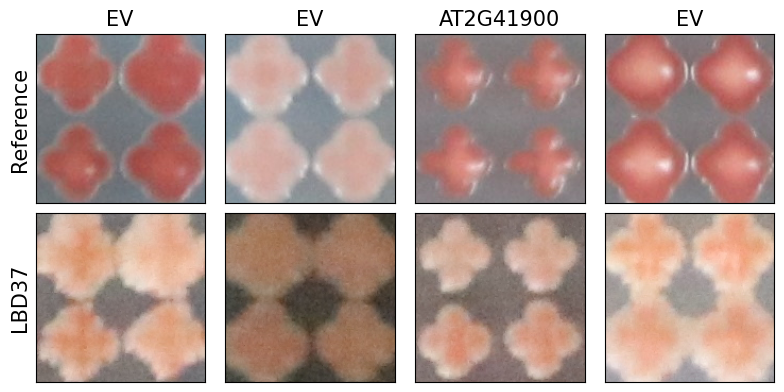

In [42]:
fs = 15
R = 80
figR = 2
fig, ax = plt.subplots(2,len(signif), figsize=(len(signif)*figR, 2*figR), sharex=True, sharey=True)
ax = ax.reshape(2, len(signif))

for i in range(len(signif)):
    j = 0
    row, col = [int(foo[1:])-1 for foo in signif.iloc[i,1].split('-')[1:] ]
    
    ax[0,i].set_title(signif.iloc[i,0], fontsize=fs)
    for (cc,img) in zip([rawcoords, pltcoords],[rawimg,pltimg]):
        dots = cc[2*row : 2*row + 2, 2*col : 2*col + 2]
        center = np.mean(np.mean(dots, axis = 0), axis = 0).astype(int)
        rss = np.s_[center[1] - R : center[1] + R, center[0] - R : center[0] + R]
        ax[j,i].imshow(img[rss], vmin=0, origin='upper'); j+=1
ax[0,0].set_ylabel('Reference', fontsize=fs)
ax[1,0].set_ylabel(lgenes[lgidx], fontsize=fs)
for a in ax.ravel():
    a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

fig.tight_layout();
#plt.savefig('foo.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})